<a href="https://colab.research.google.com/github/einsteinxx/UCLA_BIOENG_596_FALL_21/blob/main/Produce_Images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CODE SETUP


1.   Library Imports
2.   Set data specific Google Drive folders



'keep_Highscore' function original design from Anil Yadav:
 https://github.com/akre96/BUS_tumor_classification/tree/master/segmentation_model/experiments_FasterR-CNN

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import gc  #debug memory leaks in matplotlib
import csv #read in description files
import random #used to select random slice for patches
import cv2
import re #regexp for BUSI files
from skimage import exposure  #image equalization

!pip3 install -q torchinfo
!pip3 install -Uqq ipdb
################################################################################
#ULTRASOUND NEEDS
import PIL
#from PIL import Image
# Open the image form working directory
#image = Image.open(full_file)
from matplotlib import image
from ast import literal_eval #used to break out bounding boxes from strings
import time
import torch
import torchvision
import torchinfo

from torchinfo import summary
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

from numpy import clip

import torchinfo


#import ipdb  #debugger tool 
################################################################################

eps = 1e-16 #keep div by 0 away


from google.colab.patches import cv2_imshow
#
# Read Data from google drive
#
from google.colab import drive #for loading gdrive data
from google.colab import files

# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug
!pip3 install -q pickle5

import pydicom #to read dicom files
from pydicom import dcmread
import pickle5 as pickle; #generic storage of image array

#!pip3 install -q reportlab #pdf creation tool for writing review images

!pip3 -q install PdfPages
from matplotlib.backends.backend_pdf import PdfPages
################################################################################
# Load data from google drive
################################################################################
drive.mount('/content/gdrive')




#storage areas 
data_dir = '/content/gdrive/Shareddrives/BreastUS'
local_dir = '/content/gdrive/My Drive/BreastUS' #for local storage
model_dir = '/content/gdrive/My Drive/BreastUS/MODEL_SAVE'
tensorboard_dir =  '/content/gdrive/My Drive/BreastUS/TENSORBOARD_SUMMARIES'


#
# UCLA specific data folders
#
csv_dir = os.path.join(data_dir,'Annotated data')

annotated_dir = os.path.join(data_dir,'Annotated data')

data_files = os.listdir(annotated_dir)
label_data_dir = os.path.join(annotated_dir,'LabelMe_3.0_format_updated')
label_files = os.listdir(label_data_dir)

#
# Alternative set of Ultrasound data
#
use_USnorm = 0
if (use_USnorm == 1): #use norm based on US data, not imagenet

    #busi_main_dir = '/content/gdrive/My Drive/BreastUS/BUSI_DATA' #downloaded BUSI
    busi_main_dir = '/content/gdrive/My Drive/BreastUS/0TO1NORM/BUSI_DATA_CONTRAST_EQUALIZED'
    #output converted BUSI images go in here:
    ucla_converted_main_dir = '/content/gdrive/My Drive/BreastUS/0TO1NORM/UCLA_DATA_CONTRAST_EQUALIZED'
else: #use the Imagenet norms
    #busi_main_dir = '/content/gdrive/My Drive/BreastUS/BUSI_DATA' #downloaded BUSI
    busi_main_dir = '/content/gdrive/My Drive/BreastUS/N2TO2_NORM/BUSI_DATA_CONTRAST_EQUALIZED'
    #output converted BUSI images go in here:
    ucla_converted_main_dir = '/content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED'    

#
# Stored output images
#
ucla_output_image_dir = '/content/gdrive/My Drive/BreastUS/UCLA_OUTPUT_IMAGES'


################################################################################
#      GPU OPTIONS
### Enable GPU, if present
################################################################################
train_on_gpu = torch.cuda.is_available()
if (train_on_gpu):
    !nvidia-smi -L
    !nvidia-smi 
    dev=torch.device("cuda")
else:
    print('GPU NOT FOUND!!! USING CPU INSTEAD!!!!!')
    dev=torch.device("cpu")


     |████████████████████████████████| 793 kB 5.5 MB/s 
     |████████████████████████████████| 381 kB 37.0 MB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-console 5.2.0 requires prompt-toolkit<2.0.0,>=1.0.0, but you have prompt-toolkit 3.0.30 which is incompatible.
google-colab 1.0.0 requires ipython~=5.5.0, but you have ipython 7.34.0 which is incompatible.
     |████████████████████████████████| 2.0 MB 8.3 MB/s 
     |████████████████████████████████| 256 kB 8.3 MB/s 
     |████████████████████████████████| 208 kB 7.7 MB/s 
Mounted at /content/gdrive
GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-adf4d4fe-bca1-865a-7004-d71c1615236a)
Mon Aug 15 08:50:21 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|----------------------------

In [2]:
print(torch.__version__)
print('Using Training option ', training_set)

1.12.1+cu113


NameError: ignored

In [3]:
class CustomDataset(torch.utils.data.Dataset):
    #
    # This function handles the majority of the tensor data creation and label
    #assignments. It can handle two types of data, 0 for UCLA, and 1 for BUSI.
    #
    #
    #

    

    def __init__(self,
                 img_dir,
                 bounding_boxes,
                 label_data,
                 category=[],
                 file_count=1,
                 file_list =[],
                 data_type = 0, #0=UCLA, 1 = BUSI
                 transform=None,
                 target_transform=None):
        #self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.label_data = label_data
        self.bounding_boxes = bounding_boxes
        self.category = category
        self.file_count = file_count
        self.file_list = file_list
        self.transform = transform
        self.target_transform = target_transform
        self.category_name =''
        self.transform = transforms.Compose([transforms.ToTensor()])
        self.imgs = file_list
        self.data_type = data_type


    def __getitem__(self, index):

        eps = 1e-16 #keep div by 0 away

        dbprint = 0
        image_dir = self.img_dir
        bounding_boxes_data = self.bounding_boxes[index]
        file_name = self.file_list[index]
        file_label = self.label_data[index] #for this index, the label stored

        #print('--------------------------------------------------')
        #print(file_name)
        #print('image id ', index)

        ########################################################################
        #
        # BUSI Data loading
        #
        ########################################################################
        if (self.data_type == 2): #BUSI Images
            #all of the cropping, normalization, equalization done in 
            #the pre-processing stage. We just load in the 3d volume 
            img = pickle.load( open( file_name, "rb" ) )
            #img=cropped_image.astype(np.double)

            #get original image sizes, which are part of the 
            #filenames. An example will be:
            #  'malignant (208).png_664_617.pck'
            fnumber = re.findall(r"\d+",file_name)
            #0TO1_NORM is the first set of 2 integers in the name
            #filenum = int(fnumber[2])
            oldr = int(fnumber[3])
            oldc = int(fnumber[4])
            #get nr, nc from image filename np.shape(cropped_image) #image shape before resize
            skip_points = [0,0,0,0] #image was pre-cropped, nothing to skip
            fail_crop=0 #cropping done externally, so set to 0
        
        ########################################################################
        #
        # UCLA Data loading
        #
        ########################################################################
        elif (self.data_type == 0): #UCLA Data
            #all of the cropping, normalization, equalization done in 
            #the pre-processing stage. We just load in the 3d volume 

            if os.path.getsize(file_name) < 0:
                print('empty file --- ', file_name)
                dbprint =1
            else:
                try:
                    img = pickle.load( open( file_name, "rb" ) )
                except:
                    print('ERROR IN: ', file_name)

            #ucla_path = '/content/gdrive/My Drive/BreastUS/0TO1_NORM/UCLA_DATA_CONTRAST_EQUALIZED'
            cut_index = file_name.index(ucla_converted_main_dir) + len(ucla_converted_main_dir)+1

        
            short_name = file_name[cut_index:]  #removed the starting directory
            parts = short_name.split('/')
            if (dbprint == 1):
                print('file_name[] ',file_name[cut_index:])
                print(parts)
            video_part = parts[0] #get the video idea from the parsed string
            fileonly = os.path.basename(file_name) #filename without full pathing
            #converted_name = fname.replace(old_string, new_string)

            #get the original image sizes from the filename
            fnumber = re.findall(r"\d+",fileonly)
            temp_frameid = fnumber[0]  #frame id


            fnumber = re.findall(r"\d+",fileonly) #_name)
            oldr = int(fnumber[1])
            oldc = int(fnumber[2])
            skip_points =[]
            for xx in fnumber[3:]:
                skip_points.append(int(xx))
            if (dbprint == 1):
                print('oldr, oldc = ', oldr, oldc)
                print('skip points ', skip_points)
                print(bounding_boxes_data)
            #get nr, nc from image filename np.shape(cropped_image) #image shape before resize
            
            fail_crop=0 #cropping done externally, so set to 0
            

        else:
            stop

            
        ########################################################################
        # Processing to run over every type of data
        #
        ########################################################################

                #
        # Scaling values for adjusting annotation box coordinates
        # - since the images are likely upsized, the annotations need to be scaled
        # by an amount to correspond to the new image size
        #
        nr,nc = np.shape(img[0,:,:]) #this is the new resized image
        box_scalex = nc/oldc
        box_scaley = nr/oldr
        #
                #bbox = torch.FloatTensor(corners)

        # get bounding box coordinates for each mask
        num_objs = len(self.file_list) #bounding_box)
        boxes = []
        #area = 0
        pos=literal_eval(bounding_boxes_data)#[index])


        #if (len(corners)>0):
        #    width = xmax-xmin
        #    height = ymax-ymin
        #    rect = patches.Rectangle((offset_col,offset_row),width,height,linewidth=1,edgecolor='r',facecolor='none')
        #skip_points = [low_row, high_row,start_column, final_column]

        if (dbprint == 1):
            corners=literal_eval(bounding_boxes_data)#[index])
            print('corners ',pos)

        #pos = np.double(pos)
        if (len(pos) !=0): #(pos):

            pos = np.int32(pos)
            xmin = pos[0][0]
            xmax = pos[1][0]
            ymin = pos[0][1]
            ymax = pos[2][1]
            ### Correct for the cropped image as annotation points are for the 
            ### main image with subset
            offset_row = ymin-skip_points[0]
            offset_col = xmin-skip_points[2]
            max_row = ymax - skip_points[0]
            max_col = xmax - skip_points[2]

            #boxes.append([offset_col, offset_row, 
            #              xmax-skip_points[2], 
            #              ymax-skip_points[0]])
            x0 = offset_col * box_scalex
            y0 = offset_row * box_scaley
            x1 = max_col * box_scalex
            y1 = max_row * box_scaley

            if (dbprint ==1):
                print('----------------------------------')
                print('xo,yo,x1,y1 = ',x0,y0,x1,y1)
                print('box scale x,y ',box_scalex, box_scaley)
                print('offset col, row =',offset_col, offset_row)
                print('skip points ',skip_points)
                print('nr,nc = ', nr,nc)
                print('oldc, oldr = ', oldc, oldr)
                print('-----------------------------------')

            w = x1-x0
            h = y1-y0
            if ((w <10) or (h <10)):
                print('!!!!!! Unusable h/w found: ',h,w)
                print(x0,y0,w,h)
                print('box scale x,y ',box_scalex, box_scaley)
                print('xmin,ymin,xmax,ymax ',xmin,ymin,xmax,ymax)
                print('index is ',index)
                print('skip points ',skip_points)
                print('offset col, row =',offset_col, offset_row)
            boxes.append([x0,y0,x1,y1])
            #boxes.append([offset_col*box_scalex,
            #              offset_row*box_scaley,
            #              (xmax-skip_points[2])*box_scalex,
            #              (ymax-skip_points[0])*box_scaley])
            if (dbprint == 1):
                print('boxes= ',boxes)

            if (dbprint == 1):
                print('offsets are (col,row) ',offset_col, offset_row)
                print('skip points are ', skip_points)
                print('xmax,min,ymax,min = ', xmax,xmin, ymax,ymin)
            #boxes.append([xmin, ymin, xmax, ymax])
            #area = (xmax-skip_points[0] - offset_col) * (ymax-skip_points[2] - offset_row) 
            #adjust area to include new scaled box sizes
            area = ((xmax-skip_points[0] - offset_col)*box_scalex) * ((ymax-skip_points[2] - offset_row) * box_scaley)
            #area += (xmax-xmin)*(ymax-ymin)#!! alter this


        # Handle empty bounding boxes
        # -- UCLA data without an annotation is benign.
        # -- BUSI data without an annotation is normal, but benign cases will 
        #    have an annotation along with malignant

        #if there isn't an annotation (pos is empty)
        if (len(pos) ==0): #num_objs == 0:
            #boxes.append([0,0,0,0])
            #boxes.append([0,0,5,5]) #testing out something with an area
            #boxes = torch.zeros((1, 4), dtype=torch.double)
            #try using the whole image as negative
            nz,nr,nc = np.shape(img)
            #print('--- ',nz,nr,nc)
            boxes = torch.zeros((0, 4), dtype=torch.float32)
            #trying empty boxes instead of full size images
            #boxes.append([0.0,0.0,0.0,0.0])

            #### works: boxes.append([0.0,0.0,nc,nr])
            area = nr*nc
            boxes = torch.as_tensor(boxes, dtype=torch.double)
            #print('empty box size is ',np.shape(boxes))
            #boxes = torch.zeros((0, 4), dtype=torch.double)
            #area = 0 #10*10
            area = torch.as_tensor(area, dtype=torch.double)

            '''
            #label = torch.as_tensor(0, dtype=torch.int64) #put as background if no boxes
            if ('B' in file_label): #benign case, label should be 0
                label = torch.zeros((1,), dtype=torch.int64)
            elif ('M' in file_label): #malignant case, label should be 1
                label = torch.ones((1,), dtype=torch.int64)
            else: #something else made it through, database problem
                print('!!!LABEL ERROR!!!')
            '''


            label = torch.zeros((1,), dtype=torch.int64)

            iscrowd=torch.ones((1,), dtype=torch.int64)

        else:
            boxes = torch.as_tensor(boxes, dtype=torch.double) 
            #print('filled box size is ',np.shape(boxes))
            area = torch.as_tensor(area, dtype=torch.double)
        
            #label = torch.as_tensor(1, dtype=torch.int64)
            label = torch.ones((1,), dtype=torch.int64)
            iscrowd=torch.zeros((1,), dtype=torch.int64)


        # Use a generic label setup for UCLA, as the test directories contain
        # Malignant cases without annotations
        #if (len(pos) ==0): #Benign and normal
        #    label = torch.zeros((1,), dtype=torch.int64)
        #else:
        #    label = torch.ones((1,), dtype=torch.int64)

            ''' Use for labels
            if ('B' in file_label): #benign case, label should be 0
                label = torch.zeros((1,), dtype=torch.int64)
            elif ('M' in file_label): #malignant case, label should be 1
                label = torch.ones((1,), dtype=torch.int64)
            else: #something else made it through, database problem
                print('!!!LABEL ERROR!!!')
                stop
            '''

        #
        # Protect against zero images from earlier in this function.
        #
        if (fail_crop == 1):
            #force this image to be a background image for training
            print('forcing image as background for failed image')
            label = torch.zeros((1,), dtype=torch.int64)
            iscrowd=torch.ones((1,), dtype=torch.int64)

        if (dbprint == 1):
            print('shape of boxes is ', np.shape(boxes))


        # there is only one class
        #labels = torch.ones((num_objs,), dtype=torch.int64)
        #masks = torch.as_tensor(masks, dtype=torch.uint8)

        #image_id = torch.tensor([idx])
        #area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        ###iscrowd = torch.zeros((len(self.imgs),), dtype=torch.double)

        if (dbprint == 1):
            print('setting target')
            print('label is ', label, type(label))
            print('area is ', area)
        


        target = []
        d = {}
        d['boxes'] = boxes  #np.squeeze(boxes,0)
        d['labels'] = label
        d['image_id'] = torch.as_tensor(index, dtype=torch.double) 
        d['area'] = area 
        d['iscrowd'] = iscrowd 
        target.append(d)

        #self.transform(self.x_data[index]), self.transform(self.y_data[index])
        #return {'image': torch.from_numpy(image),
#                'landmarks': torch.from_numpy(landmarks)}
        #return self.transform(img), self.transform(target)
        
        #print('image type before is ', type(img))
        img = torch.as_tensor(img, dtype=torch.float32) #model has float32 
        #img= torch.from_numpy(img)
        #print('image type after is ', type(img))
        #img = torchvision.transforms.ToTensor()(image)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [4]:
##### SCRATCH
subdir = 'UCLA_N2TO2_B1B2'
mname = 'BestIOU_0.2588859125971794_epoch230'
last_data_list = os.path.join(model_dir, subdir,'last_data_set.pickle')
archived_data = pickle.load( open( last_data_list, "rb" ) )

training_data = archived_data[0][0]
validation_data = archived_data[0][1]
test_data =archived_data[0][2]
bounding_box = archived_data[0][3]
first50 =archived_data[0][4]

## COLLECT FILE DATA

In [14]:
data_set = 1 #0=training, 1 = validation, 2 = test data sets


 
#print('File name :    ', os.path.basename(__file__))
#print('Directory Name:     ', os.path.dirname(__file__))

archived_data[0][0]
training_info ={}
validation_info ={}
test_info ={}

if (data_set == 0):
    pdf_file = '/content/gdrive/MyDrive/training_data_examples.pdf'
    for counter, (ii,label) in enumerate(zip(training_data.file_list, training_data.label_data)):
        #print(os.path.dirname(ii))
        training_info[counter] = {}
        training_info[counter]['full_file'] = ii
        training_info[counter]['path'] = os.path.dirname(ii)
        training_info[counter]['file'] = os.path.basename(ii)
        training_info[counter]['label'] = label
        training_info[counter]['id'] = counter

elif( data_set == 1):
    pdf_file = '/content/gdrive/MyDrive/validation_data_examples.pdf'
    for counter, (ii,label) in enumerate(zip(validation_data.file_list, validation_data.label_data)):
        #print(os.path.dirname(ii))
        validation_info[counter] = {}
        validation_info[counter]['full_file'] = ii
        validation_info[counter]['path'] = os.path.dirname(ii)
        validation_info[counter]['file'] = os.path.basename(ii)
        validation_info[counter]['label'] = label
        validation_info[counter]['id'] = counter
else:
    pdf_file = '/content/gdrive/MyDrive/testing_data_examples.pdf'
    for counter, (ii,label) in enumerate(zip(test_data.file_list, test_data.label_data)):
        #print(os.path.dirname(ii))
        test_info[counter] = {}
        test_info[counter]['full_file'] = ii
        test_info[counter]['path'] = os.path.dirname(ii)
        test_info[counter]['file'] = os.path.basename(ii)
        test_info[counter]['label'] = label
        test_info[counter]['id'] = counter




In [ ]:
for ii in training_data.file_count:
    print(ii)
    break

TypeError: ignored

In [ ]:
'''
import Image
import matplotlib.pyplot as plt
import cStringIO
from reportlab.pdfgen import canvas
from reportlab.lib.units import inch, cm

from reportlab.lib.utils import ImageReader

fig = plt.figure(figsize=(4, 3))
plt.plot([1,2,3,4])
plt.ylabel('some numbers')

imgdata = cStringIO.StringIO()
fig.savefig(imgdata, format='png')
imgdata.seek(0)  # rewind the data

Image = ImageReader(imgdata)

c = canvas.Canvas('test.pdf')
c.drawImage(Image, cm, cm, inch, inch)
c.save()

In [ ]:
'''
!ls '/content/sample_data'
pdf_file = '/content/gdrive/MyDrive/samplepdf.pdf'
#pdf_file = '/content/sample_data/mypdf.pdf'
'''
'''
from reportlab.pdfgen import canvas

my_canvas = canvas.Canvas(pdf_file)
my_canvas.drawString(100, 750, "Welcome to Reportlab!")
my_canvas.save()
'''

anscombe.json		      mnist_test.csv
california_housing_test.csv   mnist_train_small.csv
california_housing_train.csv  README.md


'\nfrom reportlab.pdfgen import canvas\n\nmy_canvas = canvas.Canvas(pdf_file)\nmy_canvas.drawString(100, 750, "Welcome to Reportlab!")\nmy_canvas.save()\n'

## LOAD IMAGE FILES

In [ ]:
#!pip3 -q install PdfPages
#from matplotlib.backends.backend_pdf import PdfPages

'''
with PdfPages('foo.pdf') as pdf:
    # As many times as you like, create a figure fig and save it:
    fig = plt.figure()
    pdf.savefig(fig)
    # When no figure is specified the current figure is saved
    pdf.savefig()
'''

     |████████████████████████████████| 207 kB 3.3 MB/s 


"\nwith PdfPages('foo.pdf') as pdf:\n    # As many times as you like, create a figure fig and save it:\n    fig = plt.figure()\n    pdf.savefig(fig)\n    # When no figure is specified the current figure is saved\n    pdf.savefig()\n"

#CREATE PDF FILES

In [15]:

if (data_set == 0):
    keyvals = training_info.keys()
    temp_dict = training_info
elif(data_set == 1):
    keyvals = validation_info.keys()
    temp_dict = validation_info
else:
    keyvals = test_info.keys()
    temp_dict = test_info


#temp_dict= training_info

old_patient_folder = ''

data_total_images = 0

current_patient_total = 0
with PdfPages(pdf_file) as pdf:
    counter = -1 #set up to follow zero index
    total=0 #keep count of images in video set

    for kk in keyvals:
        counter+=1
        filename = temp_dict[kk]['full_file']

        data_total_images +=1

        #Get file name and info for plot text
        patient_folder = os.path.dirname(os.path.dirname(filename))
        tname = os.path.basename(patient_folder)

        
        if (counter == 0): #don't do a matching patient check at start
            pass
        else:
            if (old_patient_folder == patient_folder):
                #skip this one, we just want one example from each patient
                total+=1 #add one the number of images with this name
                current_patient_total+=1
                continue
            #if a new patient, load it and paste the image
            else:
                print('total, patient # images: ',total,current_patient_total, old_patient_folder)
                old_patient_folder = patient_folder #keep a record of previous patient
                current_patient_total = 0
                
        #load image data from pickle file
        img = pickle.load( open( filename, "rb" ) )

        fig=plt.figure(figsize=(8, 6), dpi=80)
        plt.imshow(img[1,:,:],cmap='gray')
        plt.colorbar()


        
        plt.title(tname + str('\n') +str(temp_dict[kk]['id']) )
        
        pdf.attach_note("test text here")  # attach metadata (as pdf note) to page
        
        pdf.savefig(fig)
        plt.close()


        #if (counter > 500):
        #    break
    print('total images ',data_total_images)

total, patient # images:  0 0 
total, patient # images:  72 72 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_2742383t_a_l3y4l7p0_1.mp4-2022_02_06_20_13_25-labelme 3.0.zip
total, patient # images:  123 51 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_2742383t_a_l3y4l7p0_2.mp4-2022_02_06_20_03_23-labelme 3.0.zip
total, patient # images:  221 98 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_845s1010_a_9t266v59_1.mp4-2022_01_31_02_04_53-labelme 3.0.zip
total, patient # images:  597 376 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_845s1010_a_9t266v59_2.mp4-2022_01_31_02_17_51-labelme 3.0.zip
total, patient # images:  631 34 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_845s1010_a_9t266v59_3.mp4-2022_01_31_02_20_15-labelme 3.0.zip
total, patient # images:  770 139 /content/gdrive/My Drive/BreastUS/N2TO2_NORM/UCLA_DATA_CONTRAST_EQUALIZED/1_g2rn

#READ UCLA FILE LISTING FROM DATA FILES

In [10]:




model_type = 4 #0=UCLA, 1 = -2 to 2 norm UCLA all others = BUSI

if (model_type == 0):
    subdir = '0TO1_UCLA_BEST'
    mname = 'BestIOU_0.2930135428905487'
elif (model_type == 1):
    subdir = 'UCLA_FINAL'
    mname = 'BestIOU_0.3265211880207062'
elif (model_type == 3):
    print('Loading MODEL 3')
    subdir = 'BATCH2_UCLA_0TO1'
    mname = 'BestIOU_0.6398819949891832' #'fasterrcnn_trained_last_epoch29' #  'BestIOU_0.6398819949891832'
elif(model_type==4):
    subdir = 'UCLA_N2TO2_B1B2'
    mname = 'BestIOU_0.41917301155626774'
else:
    subdir = '0TO1_BUSI_BEST'
    mname = 'BestIOU_0.7361612431704998'

model_dict=os.path.join(model_dir, subdir, mname)
                        




#
# Load relevant saved train/validation/test file sets
#
print('Loading previous set of train/val/test files')
#subdir = '0TO1_UCLA_BEST'
last_data_list = os.path.join(model_dir, subdir,'last_data_set.pickle') #0TO1
#'/content/gdrive/My Drive/BreastUS/MODEL_SAVE/UCLA_FINAL/last_data_set.pickle'

archived_data = pickle.load( open( last_data_list, "rb" ) )
training_data = archived_data[0][0]
validation_data = archived_data[0][1]
test_data =archived_data[0][2]
bounding_box = archived_data[0][3]
first50 =archived_data[0][4]




data_file = os.path.join(model_dir,subdir,'train_val_test_data.pickle')
[train_list, train_labels,
    train_box,
    val_list,
    val_labels,
    val_box, 
    test_list,
    test_labels,
    test_box]=pickle.load(open(data_file, "rb"))

'''
pickle.dump([train_list,
            train_labels,
            train_box,
            val_list,
            val_labels,
            val_box, 
            test_list,
            test_labels,
            test_box,],open( data_file, "wb" ),protocol=5 )
'''

Loading previous set of train/val/test files


'\npickle.dump([train_list,\n            train_labels,\n            train_box,\n            val_list,\n            val_labels,\n            val_box, \n            test_list,\n            test_labels,\n            test_box,],open( data_file, "wb" ),protocol=5 )\n'

counter at 0


ValueError: ignored

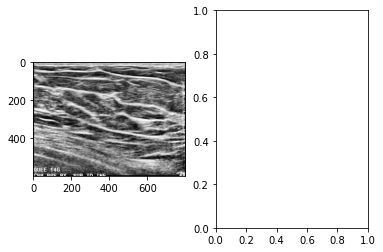

In [13]:
box_counter = 0
image_count =0
for counter, ii in enumerate(training_data.file_list):

    if (counter%200 == 0):
        print('counter at {}'.format(counter))

    box_data = training_data.bounding_boxes[counter]
    image_id = counter
    if (len(box_data) == 0): #ii[1][0]['boxes'])==0):
        continue
    else:
        img = pickle.load( open( ii, "rb" ) )
        #box_data = ii[1][0]['boxes'][0]
        #image_id = ii[1][0]['image_id']
        #print(box_data)
        #img = ii[0]
        box_counter +=1

        original_file = train_list[image_id]
        

    #img = ii[0]
    #print(np.shape(img))
    #print(ii[1][0].keys())
    box_counter +=1
    if ((box_counter % 100)==0):
        original_image = pickle.load(open(original_file,"rb"))
        plot_annotations(img, box_data, image_id, original_image)
        image_count +=1

    if (image_count > 10):
        break

In [ ]:
training_data.

#PLOT BOUNDING BOXES

In [12]:
def plot_annotations(img_data, box_data, image_id, original_image):

    fig, (ax1, ax2) = plt.subplots(1, 2)
    #plt.figure(figsize=(8, 6), dpi=80)
    #    ax1.plot(x, y)
    #ax1.set_title('Sharing Y axis')
    #ax2.scatter(x, y)
    ax1.imshow(img_data[1,:,:], cmap='gray')
    #plt.imshow(img_data[1,:,:],cmap='gray')


    #ax = plt.gca()
    if (len(box_data) == 0):
        pass
    else:
        rect = patches.Rectangle((np.uint(box_data[0]),
                                np.uint(box_data[1] )), #np.uint(bdata[1].cpu() )),
                                np.uint(box_data[2])-(np.uint(box_data[0])),
                                np.uint(box_data[3])-(np.uint(box_data[1])),
                                linewidth=1.5,edgecolor='r',facecolor='none')

    '''
    if (len(target_boxes)==0):
        #skip this, no rectangular annotation to plot
        pass
    else:
        rect2 = patches.Rectangle((np.uint(target_boxes[0][0].cpu()),
                                np.uint(target_boxes[0][1].cpu() )),
                                np.uint(target_boxes[0][2].cpu())-(np.uint(target_boxes[0][0].cpu())),
                                np.uint(target_boxes[0][3].cpu())-(np.uint(target_boxes[0][1].cpu())),
                                linewidth=1.2,edgecolor='k',facecolor='none')
    '''


        # Add the patch to the Axes
    if (len(box_data) >0):
        ax1.add_patch(rect)
        legend_text = ['Annotation']

    plt.legend(legend_text)
    plt.colorbar()
    plt.title(str(image_id))

    figsave =0
    if(figsave == 1):
        #close this figure after writing image to drive
        save_file = os.path.join(savedir,savename)
        plt.savefig(save_file)
        plt.close()

# PLOT ANNOTATIONS AND PREDICTED BOX

In [ ]:
def annotation_plot(img,
                    eval_label,
                    iou, 
                    score, 
                    calc_label, 
                    pred_boxes, 
                    target_boxes,
                    savedir ='',
                    savename='',
                    figsave=0):
    ############################################
    #MATPLOTLIB STUFF
    ############################################
    plt.figure(figsize=(8, 6), dpi=80)
    plt.imshow(img[1,:,:],cmap='gray')


    #iou_value = f'{iou:.2f}'

    '''
    if (len(eval_label) >0):
        label_value = f'{eval_label[0]:.1f}'
    else:
        label_value = 'N/A'
    '''

    
    if (score > 0):
        score_value = score#f'{score[0]['scores']:.1f}'
    else:
        score_value = 0.0 #'N/A'
    if (torch.is_tensor(iou)):
        print('found a tensor iou')
        iou = iou.numpy()
    if (calc_label ):
        plabel = calc_label
    else:
        plabel = 0 #'N/A' is the output, but it stands for background
        
    #number format for use in figure title
    iou_value = '{:04.2f}'.format(iou)
    score_value = '{:04.2f}'.format(score_value)
    
    ttext = 'iou=' + str(iou_value)+'_Plabel='+str(plabel)+'_Pscore_'+str(score_value)
    plt.title(ttext)
    #print('iou = ', iou)
    #print('------------------------------------------')

    ax = plt.gca()
    if (len(pred_boxes['boxes']) == 0):
        pass
    else:
        rect = patches.Rectangle((np.uint(pred_boxes['boxes'][0]),
                                np.uint(pred_boxes['boxes'][1] )), #np.uint(bdata[1].cpu() )),
                                np.uint(pred_boxes['boxes'][2])-(np.uint(pred_boxes['boxes'][0])),
                                np.uint(pred_boxes['boxes'][3])-(np.uint(pred_boxes['boxes'][1])),
                                linewidth=1.5,edgecolor='r',facecolor='none')

    if (len(target_boxes)==0):
        #skip this, no rectangular annotation to plot
        pass
    else:
        rect2 = patches.Rectangle((np.uint(target_boxes[0][0].cpu()),
                                np.uint(target_boxes[0][1].cpu() )),
                                np.uint(target_boxes[0][2].cpu())-(np.uint(target_boxes[0][0].cpu())),
                                np.uint(target_boxes[0][3].cpu())-(np.uint(target_boxes[0][1].cpu())),
                                linewidth=1.2,edgecolor='k',facecolor='none')


        # Add the patch to the Axes
    if (len(pred_boxes['boxes']) >0):
        ax.add_patch(rect)
    if (len(target_boxes)==0):
        legend_text = ['Prediction']
    else:
        ax.add_patch(rect2)
        legend_text = ['Prediction', 'Annotation']
    plt.legend(legend_text)
    plt.colorbar()

    if(figsave == 1):
        #close this figure after writing image to drive
        save_file = os.path.join(savedir,savename)
        plt.savefig(save_file)
        plt.close()


    return